# Introduction

This is a step by step approach to the Employment prediction challenge.

Youth unemployment and under-employment is a major concern for any developing country, and serves as an important predictor of economic health and prosperity. Being able to predict, and understand,  which young people will find employment and which ones will require additional help,  helps promote evidence-based decision-making, supports economic empowerment, and allows young people to thrive in their chosen careers.

The objective of this challenge is to build a machine learning model that predicts youth employment, based on data from labour market surveys in South Africa.

This solution will help organisations like Predictive Insights achieve a baseline prediction of young peoples’ employment outcomes, allowing them to design and test interventions to help youth make a transition into the labour market or to improve their earnings.

# The Data

The data for this challenge comes from four rounds of a survey of youth in the South African labour market, conducted at 6-month intervals. The survey contains numerical, categorical and free-form text responses. You will also receive additional demographic information such as age and information about school level and results.

Each person in the dataset was surveyed one year prior (the ‘baseline’ data) to the follow-up survey. We are interested in predicting whether a person is employed at the follow-up survey based on their labour market status and other characteristics during the baseline.

The training set consists of one row or observation per individual - information collected at baseline plus only the target outcome (whether they were employed or not) one year later. The test set consists of the data collected at baseline without the target outcome.

The objective of this challenge is to predict whether a young person will be employed, one year after the baseline survey, based on their demographic characteristics, previous and current labour market experience and education outcomes, and to deliver an easy-to-understand and insightful solution to the data team at Predictive Insights.


# Exploratory Data Analysis

## Load libraries

In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import files
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers

## Load data

In [2]:
# Mount Google Drive to /content/drive
from google.colab import drive
drive.mount('/content/drive')

# Specify the path in My Drive to save the content
output_path = '/content/drive/MyDrive/output'

Mounted at /content/drive


In [3]:
#Load the data
df_train = pd.read_csv("/content/drive/MyDrive/input/Train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/input/Test.csv")

#Display the first few lines od the train dataset
df_train.head()

,Person_id,Survey_date,Round,Status,Tenure,Geography,Province,Matric,Degree,Diploma,...,Math,Mathlit,Additional_lang,Home_lang,Science,Female,Sa_citizen,Birthyear,Birthmonth,Target
0,Id_eqz61wz7yn,2022-02-23,2,studying,NaN,Rural,Mpumalanga,1.0,0.0,0.0,...,0 - 29 %,NaN,50 - 59 %,NaN,0 - 29 %,1,1,2000,5,0
1,Id_kj5k3g5wud,2023-02-06,4,unemployed,427.0,Suburb,North West,1.0,0.0,0.0,...,30 - 39 %,NaN,40 - 49 %,NaN,30 - 39 %,1,1,1989,4,1
2,Id_9h0isj38y4,2022-08-08,3,other,NaN,Urban,Free State,1.0,0.0,0.0,...,30 - 39 %,NaN,40 - 49 %,NaN,30 - 39 %,0,1,1996,7,1
3,Id_5ch3zwpdef,2022-03-16,2,unemployed,810.0,Urban,Eastern Cape,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,1,2000,1,0
4,Id_g4elxibjej,2023-03-22,4,studying,NaN,Urban,Limpopo,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,1,1998,12,0


In [ ]:
#Display all the columns
df_train.columns

Index(['Person_id', 'Survey_date', 'Round', 'Status', 'Tenure', 'Geography',
       'Province', 'Matric', 'Degree', 'Diploma', 'Schoolquintile', 'Math',
       'Mathlit', 'Additional_lang', 'Home_lang', 'Science', 'Female',
       'Sa_citizen', 'Birthyear', 'Birthmonth', 'Target'],
      dtype='object')

## Univariate Analysis

Let's have a look at some of the variables.

**sa_citizen**

In [ ]:
#Analyze the Sa_citizen column
df_train["Sa_citizen"].value_counts()

1    4018
0       2
Name: Sa_citizen, dtype: int64

The values where `sa_citizen` are 0 are very underrepresented. It could be a good idea to remove the rows where `sa_citizen` = 0 but that could lead to a loss of data. Alternatively, one could consider removing the column altogether.

**geography**

In [ ]:
#Analyze the Geography column
df_train["Geography"].value_counts()

Urban     2797
Rural      803
Suburb     420
Name: Geography, dtype: int64

From this, we see that candidates come from three geographical categories: Rural, Suburb, and Urban. The majority come from urban areas.

**tenure**

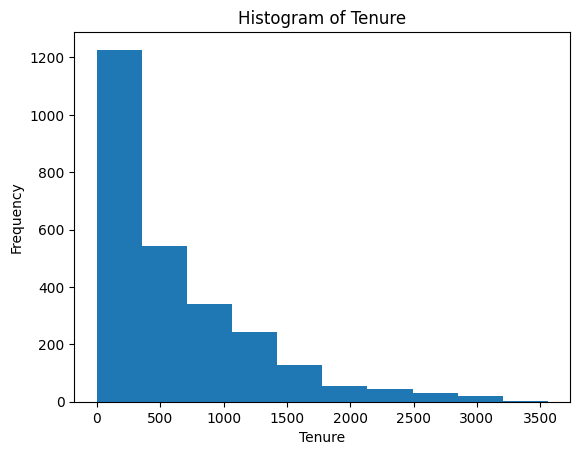

In [ ]:
# Generate a histogram of the tenure variable using matplotlib
plt.hist(df_train["Tenure"])
plt.xlabel("Tenure")
plt.ylabel("Frequency")
plt.title("Histogram of Tenure")
plt.show()

This histogram indicates that `tenure` has a skewed distribution, with a concentration of values towards the lower end and the presence of outliers.

Next, we will look at the distribution of the `birthyear` variable.

**birthyear**

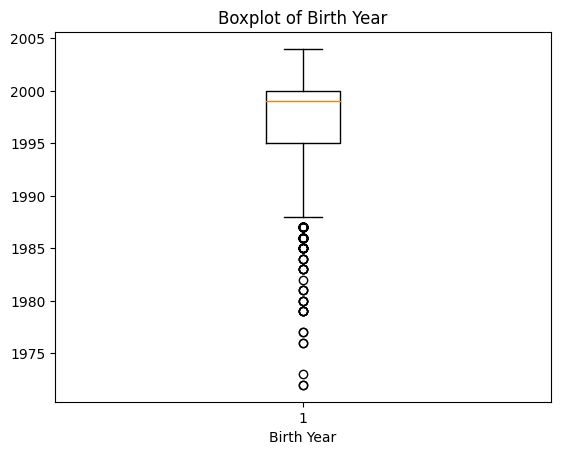

In [ ]:
# Generate a boxplot of the birthyear variable using matplotlib

plt.boxplot(df_train['Birthyear'])
plt.title("Boxplot of Birth Year")
plt.xlabel("Birth Year")

# Save the plot as an image file (e.g., PNG)
plt.savefig('/content/drive/MyDrive/output/boxplot.png')

plt.show()

The presence of many points below the first quartile suggests a left-skewed skewed distribution, with many outliers on the lower end.
To get more details, we can use the `pandas.DataFrame.describe()` function.

In [ ]:
#  get the key statistics of `birthyear` using pandas.DataFrame.describe()
df_train['Birthyear'].describe()

count    4020.000000
mean     1997.462935
std         4.378334
min      1972.000000
25%      1995.000000
50%      1999.000000
75%      2000.000000
max      2004.000000
Name: Birthyear, dtype: float64

From this, we see that most candidates were born between 1995 and 2000.

## Bivariate Analysis

Now, let us look at the relationships between a few variables and the target variables.

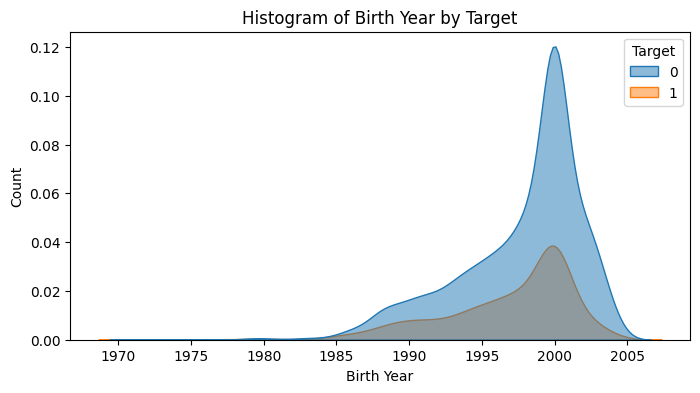

In [ ]:
#Generate histogram of birth year by target
fig, ax = plt.subplots(figsize=(8, 4))
sns.kdeplot(data=df_train, x="Birthyear", hue="Target", fill=True, alpha=0.5)
plt.xlabel("Birth Year")
plt.ylabel("Count")
plt.title("Histogram of Birth Year by Target")

# Save the plot as an image file (e.g., PNG)
plt.savefig('/content/drive/MyDrive/output/histogram.png')

plt.show()

The ages of candidates with a positive outcome and those with a negative outcome seem to follow a similar distribution.

We will now look at the percentage of candidates with a positive outcome in each province.

In [ ]:
# Calculate the percentage of positive outcome for each province

df_province = df_train.groupby('Province').agg(percentage=('Target', 'mean')).reset_index()
df_province["percentage"] = df_province["percentage"] * 100
df_province = df_province.sort_values('percentage', ascending=False).reset_index()

# print(df_province)
# json_data = df_province.to_json
# df_province.to_json(output_path + '/province.json', orient='records')
# print(json_data)
# df_province.to_csv(output_path + '/province.csv', index=False)


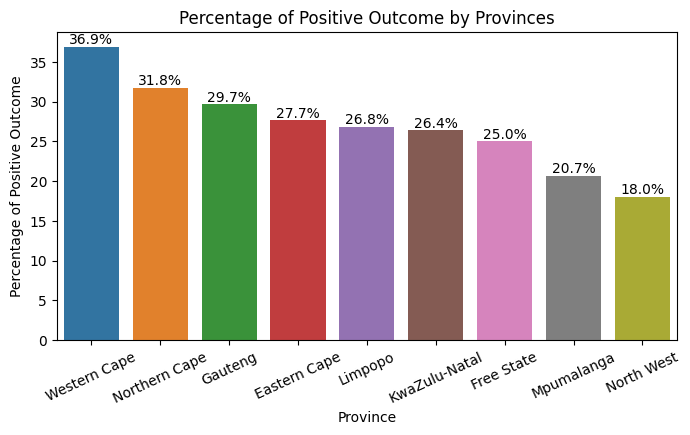

In [ ]:
# Generate a bar plot for the 'percentage' positive income for each province

plt.figure(figsize=(8, 4))
sns.barplot(data=df_province, x='Province', y='percentage')
plt.xlabel('Province')
plt.ylabel('Percentage of Positive Outcome')
plt.title('Percentage of Positive Outcome by Provinces')

for index, row in df_province.sort_values('percentage', ascending=False).iterrows():
  plt.text(row.name, row.percentage, f"{round(row.percentage, 1)}%", ha='center', va='bottom')
plt.xticks(rotation=25, ha='center')

# Save the plot as an image file (e.g., PNG)
plt.savefig('/content/drive/MyDrive/output/province_bar.png')

plt.show()

In the training data, candidates from the Western Cape are the most likely to get a positive outcome, while those from the North West province are least likely.

What about the `geography` variable?

In [4]:
# Calculate the percentage of positive outcome for each `geography`

df_geography = df_train.groupby('Geography').agg(percentage=('Target', 'mean')).reset_index()
df_geography["percentage"] = df_geography["percentage"] * 100
df_geography = df_geography.sort_values('percentage', ascending=False).reset_index()

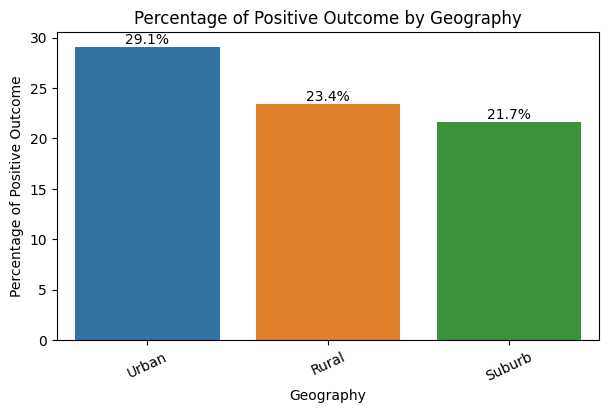

In [ ]:
# Generate a bar plot for the 'percentage' positive outcome for each `geography`

plt.figure(figsize=(7, 4))
sns.barplot(data=df_geography, x='Geography', y='percentage')
plt.xlabel('Geography')
plt.ylabel('Percentage of Positive Outcome')
plt.title('Percentage of Positive Outcome by Geography')

# Add labels to the bars
for index, row in df_geography.iterrows():
    plt.text(row.name, row.percentage, f"{round(row.percentage, 1)}%", ha='center', va='bottom')

# Rotate x-axis labels
plt.xticks(rotation=25, ha='center')

# Save the plot as an image file (e.g., PNG)
plt.savefig('/content/drive/MyDrive/output/geography_bar.png')

plt.show()

We see that people from "Urban" areas are most likely to get a positive outcome.

In terms if gender, we see below that males in the data set are more likely to get a job after one year.

In [ ]:
# Calculate the percentage of positive outcome for each `Gender``

df_female = df_train.groupby('Female').agg(percentage=('Target', 'mean')).reset_index()
df_female["percentage"] = df_female["percentage"] * 100
df_female = df_female.sort_values('percentage', ascending=False).reset_index()

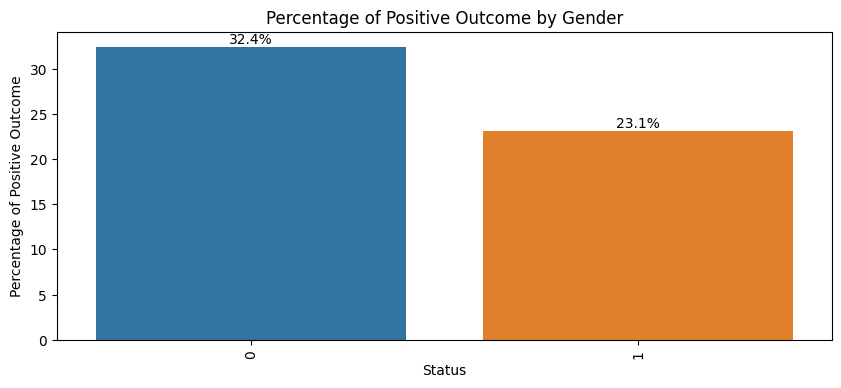

In [ ]:
# Generate a bar plot for the 'percentage' positive income for each `Gender`
plt.figure(figsize=(10, 4))
sns.barplot(data=df_female, x='Female', y='percentage')
plt.xlabel('Status')
plt.ylabel('Percentage of Positive Outcome')
plt.title('Percentage of Positive Outcome by Gender')

# Add labels to the bars
for index, row in df_female.iterrows():
    plt.text(row.name, row.percentage, f"{round(row.percentage, 1)}%", ha='center', va='bottom')

# Rotate x-axis labels
plt.xticks(rotation=90, ha='center')

plt.show()

# Feature Engineering

Feature engineering is the process of transforming raw data into meaningful features that may improve the performance of machine learning models. It involves selecting, creating, and transforming variables to capture relevant information and enhance the predictive power of the model.

Let's extract the year of the survey then use it to calculate the age of each participant at the time of the survey.

In [ ]:
#extract the year of the survey then use it to calculate the age of each participant at the time of the survey

df_train['Year_survey'] = pd.to_datetime(df_train['Survey_date']).dt.year
df_train['Age_survey'] = df_train['Year_survey'] - df_train['Birthyear']
df_train['Age_survey'].head()

0    22
1    34
2    26
3    22
4    25
Name: Age_survey, dtype: int64

Next, we create a variable that indicates the number of subjects where the participants have obtained 70% or more.

In [ ]:
#Create a variable that indicates the number of subjects where the participants have obtained 70% or more.

df_train['Subjects_over_70'] = df_train.apply(lambda row: row.str.contains("80 - 100 %|70 - 79 %").sum(), axis=1)
df_train['Subjects_over_70'].value_counts()

0    3743
1     242
2      27
3       8
Name: Subjects_over_70, dtype: int64

Feel free to explore these newly created variables and decide whether you'd like to discard them.

## Dummy variables

In this section, we convert our categorical variables into dummy variables.

In [ ]:
# Remove empty values values before feature selection
df_train = df_train.fillna(0)

In [ ]:
# Create a list of categorical variables
# selected_vars = ["Round", "Status", "Geography", "Province","Schoolquintile", "Math", "Mathlit", "Additional_lang", "Home_lang", "Science"]

selected_vars = ["Geography", "Province", "Status"]
# Remove variables we will not use
df_train_dummy = df_train.drop(["Person_id","Tenure","Math", "Survey_date", "Sa_citizen","Round","Schoolquintile", "Mathlit", "Additional_lang", "Home_lang", "Science","Year_survey","Age_survey","Subjects_over_70"], axis = 1)

# Convert character variables to dummy variables
df_train_dummy = pd.get_dummies(df_train_dummy, columns=selected_vars, drop_first=True, dummy_na=True)
df_train_dummy.columns,

(Index(['Matric', 'Degree', 'Diploma', 'Female', 'Birthyear', 'Birthmonth',
        'Target', 'Geography_Suburb', 'Geography_Urban', 'Geography_nan',
        'Province_Free State', 'Province_Gauteng', 'Province_KwaZulu-Natal',
        'Province_Limpopo', 'Province_Mpumalanga', 'Province_North West',
        'Province_Northern Cape', 'Province_Western Cape', 'Province_nan',
        'Status_other', 'Status_self employed', 'Status_studying',
        'Status_unemployed', 'Status_wage and self employed',
        'Status_wage employed', 'Status_nan'],
       dtype='object'),)

# Data cleaning

## Cleaning column names

The dummification process created some messy column names. Here, we're trying to clean those.

In [ ]:
# Clean column names
df_train_dummy.columns = df_train_dummy.columns.str.replace(' ', '_')  # Replace spaces with underscores
df_train_dummy.columns = df_train_dummy.columns.str.replace('[^\w\s]', '', regex=True)  # Remove special characters
df_train_dummy.columns = df_train_dummy.columns.str.replace('_+', '_', regex=True)  # Replace consecutive underscores with a single underscore
df_train_dummy.columns = df_train_dummy.columns.str.rstrip('_')  # Remove trailing underscores at the end
df_train_dummy.columns

Index(['Tenure', 'Matric', 'Degree', 'Diploma', 'Female', 'Birthyear',
       'Birthmonth', 'Target', 'Geography_Suburb', 'Geography_Urban',
       'Geography_nan', 'Province_Free_State', 'Province_Gauteng',
       'Province_KwaZuluNatal', 'Province_Limpopo', 'Province_Mpumalanga',
       'Province_North_West', 'Province_Northern_Cape',
       'Province_Western_Cape', 'Province_nan', 'Status_other',
       'Status_self_employed', 'Status_studying', 'Status_unemployed',
       'Status_wage_and_self_employed', 'Status_wage_employed', 'Status_nan'],
      dtype='object')

In [ ]:
#View after cleaning data
df_train_dummy.head()

,Tenure,Matric,Degree,Diploma,Female,Birthyear,Birthmonth,Target,Geography_Suburb,Geography_Urban,...,Math_70_79,Math_80_100,Math_nan,Status_other,Status_self_employed,Status_studying,Status_unemployed,Status_wage_and_self_employed,Status_wage_employed,Status_nan
0,0.0,1.0,0.0,0.0,1,2000,5,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,427.0,1.0,0.0,0.0,1,1989,4,1,1,0,...,0,0,0,0,0,0,1,0,0,0
2,0.0,1.0,0.0,0.0,0,1996,7,1,0,1,...,0,0,0,1,0,0,0,0,0,0
3,810.0,0.0,0.0,0.0,0,2000,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,0.0,0.0,0.0,0.0,1,1998,12,0,0,1,...,0,0,0,0,0,1,0,0,0,0


## Dealing with missing values

We will use a simplified method for replacing missing values: replacing them with zero.

In [ ]:
df_train_dummy = df_train_dummy.fillna(0)

In [ ]:
#View the data after removing null values
df_train_dummy.head()

,Status,Tenure,Matric,Degree,Diploma,Female,Birthyear,Birthmonth,Target,Geography_Suburb,...,Province_Western_Cape,Province_nan,Math_0_29,Math_30_39,Math_40_49,Math_50_59,Math_60_69,Math_70_79,Math_80_100,Math_nan
0,studying,0.0,1.0,0.0,0.0,1,2000,5,0,0,...,0,0,1,0,0,0,0,0,0,0
1,unemployed,427.0,1.0,0.0,0.0,1,1989,4,1,1,...,0,0,0,1,0,0,0,0,0,0
2,other,0.0,1.0,0.0,0.0,0,1996,7,1,0,...,0,0,0,1,0,0,0,0,0,0
3,unemployed,810.0,0.0,0.0,0.0,0,2000,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,studying,0.0,0.0,0.0,0.0,1,1998,12,0,0,...,0,0,0,0,0,0,0,0,0,0


**Import other libraries**

In [ ]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers

## Pre-processing the test data

We need to make sure the test data undergoes the same pre-processing steps as the training data did.

In [ ]:
# Test set preview
df_test.head()

,Person_id,Survey_date,Round,Status,Tenure,Geography,Province,Matric,Degree,Diploma,...,Additional_lang,Home_lang,Science,Female,Sa_citizen,Birthyear,Birthmonth,Year_survey,Age_survey,Subjects_over_70
0,Id_r90136smvl,2022-08-03,3,other,NaN,Urban,KwaZulu-Natal,1.0,0.0,0.0,...,50 - 59 %,NaN,40 - 49 %,0,1,2002,12,2022,20,0
1,Id_wawdqhmu6s,2023-03-16,4,unemployed,979.0,Urban,Western Cape,1.0,0.0,0.0,...,40 - 49 %,NaN,NaN,1,1,1989,12,2023,34,0
2,Id_ap2czff2bu,2023-03-14,4,unemployed,339.0,Urban,KwaZulu-Natal,0.0,0.0,0.0,...,NaN,NaN,NaN,1,1,1989,12,2023,34,0
3,Id_uhgink7iha,2023-02-16,4,studying,NaN,Urban,Gauteng,1.0,0.0,0.0,...,60 - 69 %,NaN,NaN,0,1,2002,11,2023,21,1
4,Id_5j6bzk3k81,2023-03-23,4,unemployed,613.0,Urban,Gauteng,0.0,0.0,0.0,...,NaN,NaN,NaN,1,1,1993,10,2023,30,0


In [ ]:
# Create "year_survey" column then
# Create "age_survey" column
df_test['Year_survey'] = pd.to_datetime(df_test['Survey_date']).dt.year
df_test['Age_survey'] = df_test['Year_survey'] - df_test['Birthyear']
df_test['Age_survey'].head()

0    20
1    34
2    34
3    21
4    30
Name: Age_survey, dtype: int64

In [ ]:
df_test['Subjects_over_70'] = df_test.apply(lambda row: row.str.contains("80 - 100 %|70 - 79 %").sum(), axis=1)
df_test['Subjects_over_70'].value_counts()

0    1817
1      90
2      19
3       8
Name: Subjects_over_70, dtype: int64

In [ ]:
# Remove variables we will not use
df_test_dummy = df_test.drop(["Person_id", "Survey_date","Sa_citizen" ], axis = 1)

# Convert character variables to dummy variables
df_test_dummy = pd.get_dummies(df_test_dummy, columns=selected_vars, drop_first=True, dummy_na=True)

# # Clean column names
df_test_dummy.columns = df_test_dummy.columns.str.replace(' ', '_')  # Replace spaces with underscores
df_test_dummy.columns = df_test_dummy.columns.str.replace('[^\w\s]', '', regex=True)  # Remove special characters
df_test_dummy.columns = df_test_dummy.columns.str.replace('_+', '_', regex=True)  # Replace consecutive underscores with a single underscore
df_test_dummy.columns = df_test_dummy.columns.str.rstrip('_')  # Remove trailing underscores at the end
df_test_dummy.columns


Index(['Round', 'Status', 'Tenure', 'Matric', 'Degree', 'Diploma',
       'Schoolquintile', 'Mathlit', 'Additional_lang', 'Home_lang', 'Science',
       'Female', 'Birthyear', 'Birthmonth', 'Year_survey', 'Age_survey',
       'Subjects_over_70', 'Geography_Suburb', 'Geography_Urban',
       'Geography_nan', 'Province_Free_State', 'Province_Gauteng',
       'Province_KwaZuluNatal', 'Province_Limpopo', 'Province_Mpumalanga',
       'Province_North_West', 'Province_Northern_Cape',
       'Province_Western_Cape', 'Province_nan', 'Math_30_39', 'Math_40_49',
       'Math_50_59', 'Math_60_69', 'Math_70_79', 'Math_80_100', 'Math_nan'],
      dtype='object')

In [ ]:
df_test_dummy = df_test_dummy.fillna(0)

In [ ]:
#View test set dummy after removing null values
df_test_dummy.head()

,Round,Status,Tenure,Matric,Degree,Diploma,Schoolquintile,Mathlit,Additional_lang,Home_lang,...,Province_Northern_Cape,Province_Western_Cape,Province_nan,Math_30_39,Math_40_49,Math_50_59,Math_60_69,Math_70_79,Math_80_100,Math_nan
0,3,other,0.0,1.0,0.0,0.0,2.0,0,50 - 59 %,0,...,0,0,0,0,0,0,0,0,0,0
1,4,unemployed,979.0,1.0,0.0,0.0,0.0,0,40 - 49 %,0,...,0,1,0,0,0,0,0,0,0,1
2,4,unemployed,339.0,0.0,0.0,0.0,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,studying,0.0,1.0,0.0,0.0,1.0,80 - 100 %,60 - 69 %,0,...,0,0,0,0,0,0,0,0,0,1
4,4,unemployed,613.0,0.0,0.0,0.0,5.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# Logistic Regression Modeling

Logistic Regression is a statistical modeling technique used to predict binary outcomes or probabilities. It is commonly used when the dependent variable (target variable) is categorical and has two possible outcomes, such as yes/no, success/failure, or 0/1.

To perform logistic regression with 10-fold cross-validation using scikit-learn, you can use the following code:

In [ ]:
# Separate the features and target variables

X_train = df_train_dummy.drop('Target', axis=1)
y_train = df_train_dummy['Target']

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Set up logistic regression model
model = LogisticRegression(class_weight='balanced',max_iter=3000)

# Set up cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation and calculate ROC AUC
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv)
print(y_train[:3])

2691    0
2573    1
3837    1
Name: Target, dtype: int64


In [ ]:
print(y_val[:3])

2981    0
1204    0
2720    1
Name: Target, dtype: int64


In [ ]:

# Print the mean ROC AUC score across folds
print('Mean ROC AUC:', scores.mean())

Mean ROC AUC: 0.757659061407268


Now, let's predict!

In [ ]:
# Fit the model on training set
# Train the model on the training data

model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=3000)

In [ ]:
#predict on test set

predictions = model.predict(X_val)
print(predictions[:6])

[0 0 0 0 1 0]


In [ ]:
# Display classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_val, predictions))

print("Confusion Matrix:")
cm_rf = confusion_matrix(y_val, predictions)
print(cm_rf)

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       881
           1       0.50      0.53      0.52       325

    accuracy                           0.73      1206
   macro avg       0.66      0.67      0.67      1206
weighted avg       0.74      0.73      0.73      1206

Confusion Matrix:
[[713 168]
 [154 171]]


In [ ]:
# Calculate the confusion matrix

# y_train_subset = y_train.iloc[:len(predictions)]
cm = confusion_matrix(y_val, predictions)

print ('confusion matrix')
print(cm)

confusion matrix
[[713 168]
 [154 171]]


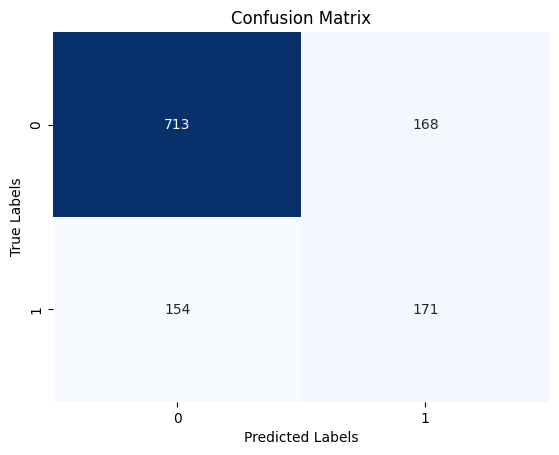

In [ ]:
# Visualize the confusion matrix using a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Optionally, calculate and display accuracy on the test set
accuracy = accuracy_score(y_val, predictions)
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.73


In [ ]:
# Save the model
joblib.dump(model, 'logistic_regression_model.joblib')

['logistic_regression_model.joblib']

Now let's put our predictions in the format needed for submission.For every row in the dataset, submission files should contain 2 columns: ID and Target.
Your submission file should look like this.

In [ ]:
print(X_val.columns)

Index(['Tenure', 'Matric', 'Degree', 'Diploma', 'Female', 'Birthyear',
       'Birthmonth', 'Geography_Suburb', 'Geography_Urban', 'Geography_nan',
       'Province_Free_State', 'Province_Gauteng', 'Province_KwaZuluNatal',
       'Province_Limpopo', 'Province_Mpumalanga', 'Province_North_West',
       'Province_Northern_Cape', 'Province_Western_Cape', 'Province_nan'],
      dtype='object')


In [ ]:
# Create a DataFrame df_submission with two columns "ID" and "Target"
df_logistic = pd.DataFrame({"Matric":X_val["Matric"], "Degree":X_val["Degree"],"Dploma":X_val["Diploma"],"Female":X_val["Female"],"Suburb":X_val["Geography_Suburb"],"Urban":X_val["Geography_Urban"],"Rural":X_val["Geography_nan"],"Free_state":X_val["Province_Free_State"],"Gauteng":X_val["Province_Gauteng"],"kzn":X_val["Province_KwaZuluNatal"],"Limpopo":X_val["Province_Limpopo"],"Mpumalanga":X_val["Province_Mpumalanga"],"North_west":X_val["Province_North_West"],"Northern_cape":X_val["Province_Northern_Cape"],"Western_cape":X_val["Province_Western_Cape"],"Target": predictions.astype(int)})
print(df_logistic.head())

      Matric  Degree  Dploma  Female  Suburb  Urban  Rural  Free_state  \
2981     0.0     0.0     0.0       0       0      1      0           0   
1204     0.0     0.0     0.0       1       0      1      0           0   
2720     0.0     0.0     0.0       1       0      1      0           0   
1954     1.0     0.0     0.0       1       0      1      0           0   
1226     1.0     0.0     0.0       0       0      0      0           0   

      Gauteng  kzn  Limpopo  Mpumalanga  North_west  Northern_cape  \
2981        1    0        0           0           0              0   
1204        1    0        0           0           0              0   
2720        0    0        0           0           0              0   
1954        0    1        0           0           0              0   
1226        0    1        0           0           0              0   

      Western_cape  Target  
2981             0       0  
1204             0       0  
2720             1       0  
1954             0

# Random Forest Modelling
Random Forest is an ensemble learning method that can be used for both classification and regression tasks. It is based on the principle of building multiple decision trees during training and merging their predictions to achieve a more accurate and robust model. Random Forest was introduced by Leo Breiman and Adele Cutler.



In [ ]:
# Separate features (X) and target variable (y)
X_train = df_train_dummy.drop('Target', axis=1)
y_train = df_train_dummy['Target']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=109)

In [ ]:
# Create a Random Forest model
rf_model = RandomForestClassifier(random_state=42)

In [ ]:
# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Make predictions on the validation set
y_val_pred = rf_model.predict(X_val)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

Validation Accuracy: 0.76


In [ ]:
# Display classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

print("Confusion Matrix:")
cm_rf = confusion_matrix(y_val, y_val_pred)
print(cm_rf)

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       882
           1       0.58      0.44      0.50       324

    accuracy                           0.76      1206
   macro avg       0.69      0.66      0.67      1206
weighted avg       0.75      0.76      0.75      1206

Confusion Matrix:
[[779 103]
 [183 141]]


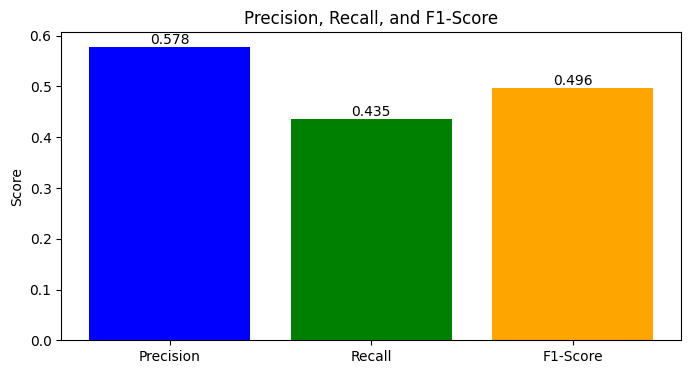

In [ ]:
#Draw a bar chart for the classification report

# Get the classification report as a dictionary
report_dict = classification_report(y_val, y_val_pred, output_dict=True)
# Extract precision, recall, and f1-score
precision = report_dict['1']['precision']
recall = report_dict['1']['recall']
f1_score = report_dict['1']['f1-score']

# Create a bar plot
labels = ['Precision', 'Recall', 'F1-Score']
values = [precision, recall, f1_score]

plt.figure(figsize=(8, 4))
bars = plt.bar(labels, values, color=['blue', 'green', 'orange'])
# Add the values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score')

# Save the plot as an image file (e.g., PNG)
plt.savefig('/content/drive/MyDrive/output/classification_report_rf.png')

plt.show()

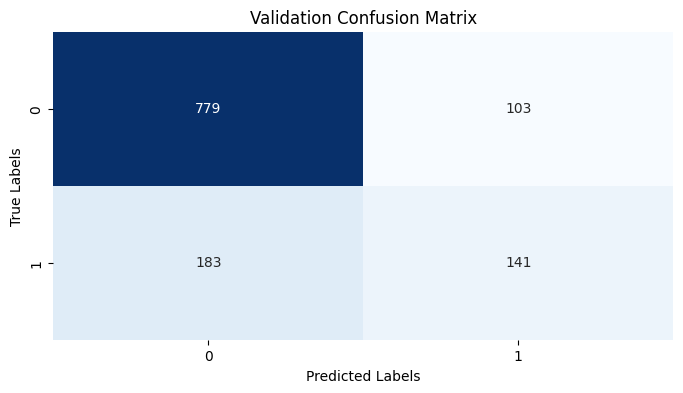

In [ ]:
# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Validation Confusion Matrix")

# Save the plot as an image file (e.g., PNG)
plt.savefig('/content/drive/MyDrive/output/confusion_matrix_rf.png')

plt.show()

In [ ]:
X_val.columns

Index(['Tenure', 'Matric', 'Degree', 'Diploma', 'Female', 'Birthyear',
       'Birthmonth', 'Geography_Suburb', 'Geography_Urban', 'Geography_nan',
       'Province_Free_State', 'Province_Gauteng', 'Province_KwaZuluNatal',
       'Province_Limpopo', 'Province_Mpumalanga', 'Province_North_West',
       'Province_Northern_Cape', 'Province_Western_Cape', 'Province_nan'],
      dtype='object')

In [ ]:
# Create a DataFrame df_random to save in csv format
df_random = pd.DataFrame({"Matric":X_val["Matric"], "Degree":X_val["Degree"],"Dploma":X_val["Diploma"],"Female":X_val["Female"],"Suburb":X_val["Geography_Suburb"],"Urban":X_val["Geography_Urban"],"Rural":X_val["Geography_nan"],"Free_state":X_val["Province_Free_State"],"Gauteng":X_val["Province_Gauteng"],"kzn":X_val["Province_KwaZuluNatal"],"Limpopo":X_val["Province_Limpopo"],"Mpumalanga":X_val["Province_Mpumalanga"],"North_west":X_val["Province_North_West"],"Northern_cape":X_val["Province_Northern_Cape"],"Western_cape":X_val["Province_Western_Cape"],"Target": predictions.astype(int)})
print(df_random.head())

      Matric  Degree  Dploma  Female  Suburb  Urban  Rural  Free_state  \
3223     0.0     0.0     0.0       1       0      1      0           0   
2138     1.0     0.0     0.0       1       0      1      0           0   
1456     1.0     0.0     0.0       1       1      0      0           0   
527      1.0     1.0     0.0       1       0      1      0           0   
263      1.0     0.0     0.0       1       0      1      0           0   

      Gauteng  kzn  Limpopo  Mpumalanga  North_west  Northern_cape  \
3223        0    1        0           0           0              0   
2138        0    0        0           0           0              1   
1456        0    0        1           0           0              0   
527         0    0        1           0           0              0   
263         1    0        0           0           0              0   

      Western_cape  Target  
3223             0       0  
2138             0       0  
1456             0       0  
527              0

Save predictions as a csv file.

In [ ]:
# Save the random forest predictions as csv(best model)
df_random.to_csv("/content/drive/MyDrive/output/random_forest.csv", index=False)

# Support Vector Machine (SVM) Modelling
Random Forest is an ensemble learning method that can be used for both A support vector machine (SVM) is a supervised machine learning algorithm that analyzes data for classification and regression analysis. SVM is used to sort data into one of two categories. It outputs a map of the sorted data with the margins between the two as far apart as possible. SVMs can be used for classification or regression tasks.


In [ ]:
# Separate features (X) and target variable (y)
X_train = df_train_dummy.drop('Target', axis=1)
y_train = df_train_dummy['Target']

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3,random_state=109) #109 70% training and 30% test

In [ ]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)


In [ ]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7313432835820896


In [ ]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))


Precision: 0.82
Recall: 0.37962962962962965


In [ ]:
# Display classification report and confusion matrix for validation set
print("Classification Report (Validation Set):")
print(classification_report(y_test, y_pred))

print("Confusion Matrix (Validation Set):")
print(confusion_matrix(y_test, y_pred))

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.81      0.97      0.88       882
           1       0.82      0.38      0.52       324

    accuracy                           0.81      1206
   macro avg       0.81      0.67      0.70      1206
weighted avg       0.81      0.81      0.78      1206

Confusion Matrix (Validation Set):
[[855  27]
 [201 123]]


# Neural Network Modelling
A neural network is a machine learning model that is inspired by the structure and function of the human brain. It uses a network of interconnected nodes or neurons that process and translate data inputs into desired outputs. Neural networks are a subset of machine learning and a core component of deep learning algorithms.

In [ ]:
# Separate features (X) and target variable (y)
X_train = df_train_dummy.drop('Target', axis=1)
y_train = df_train_dummy['Target']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=109)

In [ ]:
# Standardize features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [ ]:
# Create a simple neural network model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Assuming binary classification
])

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_val_scaled, y_val))

Epoch 1/10
88/88 [==============================] - 2s 8ms/step - loss: 0.5962 - accuracy: 0.7075 - val_loss: 0.5727 - val_accuracy: 0.7305
Epoch 2/10
88/88 [==============================] - 1s 7ms/step - loss: 0.5618 - accuracy: 0.7271 - val_loss: 0.5671 - val_accuracy: 0.7239
Epoch 3/10
88/88 [==============================] - 1s 7ms/step - loss: 0.5549 - accuracy: 0.7321 - val_loss: 0.5691 - val_accuracy: 0.7247
Epoch 4/10
88/88 [==============================] - 1s 8ms/step - loss: 0.5500 - accuracy: 0.7342 - val_loss: 0.5673 - val_accuracy: 0.7197
Epoch 5/10
88/88 [==============================] - 1s 15ms/step - loss: 0.5469 - accuracy: 0.7349 - val_loss: 0.5687 - val_accuracy: 0.7222
Epoch 6/10
88/88 [==============================] - 2s 17ms/step - loss: 0.5423 - accuracy: 0.7381 - val_loss: 0.5683 - val_accuracy: 0.7231
Epoch 7/10
88/88 [==============================] - 3s 29ms/step - loss: 0.5393 - accuracy: 0.7381 - val_loss: 0.5697 - val_accuracy: 0.7239
Epoch 8/10
88/88 

In [ ]:
# Evaluate the model on the validation set
y_val_pred_probs = model.predict(X_val_scaled)
y_val_pred_binary = (y_val_pred_probs > 0.5).astype(int)

38/38 [==============================] - 0s 2ms/step


In [ ]:
# Calculate and display accuracy on the validation set
accuracy_val = accuracy_score(y_val, y_val_pred_binary)
print(f"Validation Accuracy: {accuracy_val:.2f}")

Validation Accuracy: 0.72


In [ ]:
# Display classification report and confusion matrix for validation set
print("Classification Report (Validation Set):")
print(classification_report(y_val, y_val_pred_binary))

print("Confusion Matrix (Validation Set):")
print(confusion_matrix(y_val, y_val_pred_binary))

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       882
           1       0.70      0.43      0.53       324

    accuracy                           0.80      1206
   macro avg       0.76      0.68      0.70      1206
weighted avg       0.78      0.80      0.78      1206

Confusion Matrix (Validation Set):
[[821  61]
 [184 140]]


Predictive Insights is a leader in behavioural science and artificial intelligence to improve business efficiency and profitability. Through a combination of data science, machine learning and behavioural insights, we help customers to accurately predict sales, staffing and stock levels. Our solution improves sales forecasting on average by 50 percent. We operate in Africa as well as Europe, Middle East and India in the restaurant, food processing, retail and financial service sectors.
We are part of Alphawave, a specialised technology investment group supporting businesses seeking to do things that are complex to replicate.
